# Fitting Kepler-10 Data

In this workbook we'll go through the process of fitting Kepler data with linear models.

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np

In [50]:
workbook_data = pickle.load(open("data/workbook_1.p", "rb"))
x, y, ye = workbook_data["x"], workbook_data["y"], workbook_data["ye"]
y, ye = y / y.mean(), ye / y.mean()
period, t0, duration = (
    workbook_data["period"],
    workbook_data["t0"],
    workbook_data["duration"],
)

[Text(0.5, 0, 'Time [BKJD]'),
 Text(0, 0.5, 'Flux [e-/s]'),
 Text(0.5, 1.0, 'Kepler-10')]

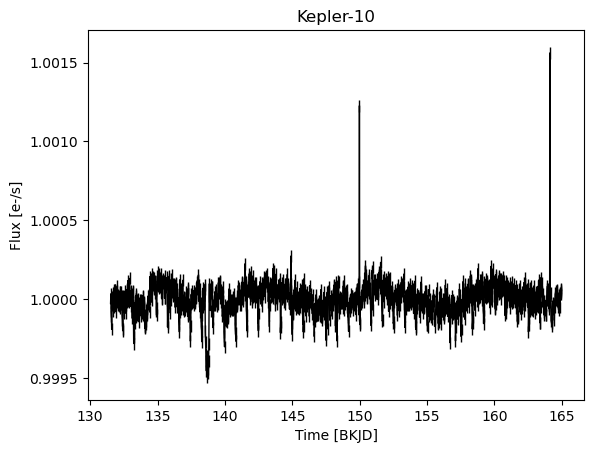

In [3]:
fig, ax = plt.subplots()
ax.errorbar(x, y, ye, color="k", lw=1)
ax.set(xlabel="Time [BKJD]", ylabel="Flux [e-/s]", title="Kepler-10")

## Step 1: Create a design matrix

Create a design matrix for the data above. The design matrix should consist of two "box" transit models (one for each planet) where the model is 0 outside of transit, and -1 during transit. The design matrix should have three vectors, including the first vector which is an offset term.

Overwrite `A` below to be your design matrix.

In [10]:
planets = -np.asarray([((x - t0[idx]) % period[idx] < duration[idx]/2) for idx in range(2)], float).T


A = np.vstack([x**0, *planets.T]).T


In [11]:
assert np.isclose(A.dot([1, 0.1, 0.2]).sum(), 1614.5, atol=0.1)

## Step 2: Find the best fitting weights
Use the Weighted Least Squares equation to find the mean best fitting weights. 

Overwrite `w` below to be your mean best fitting weights. 

In [13]:
w = np.linalg.solve(A.T.dot(A/ye[:, None]**2), A.T.dot(y/ye**2))

w

array([1.00000907e+00, 1.43104255e-04, 4.47823457e-04])

This is implicitly fitting the transit depth for the planets. Set the transit depth for each planet in `td_1` and `td_2` below.

In [14]:
td_1, td_2 = w[1],w[2]

td_1,td_2

(0.00014310425520282772, 0.0004478234565118382)

In [15]:
assert np.isclose(td_1, 0.000143104, rtol=0.1)
assert np.isclose(td_2, 0.00044782345, rtol=0.1)

## Step 3: Improving the model

Assume that the stellar rotation period is `8.235401877719259` days. Create a model for the stellar variability and improve the fit for the transit depths.

Use 

- A sinusoid to capture the stellar variability
- Weighted Least Squares
- A mask to remove outliers

In [51]:
stellar_rotation_period = 8.235401877719259

In [82]:
A = np.vstack([np.sin(2*np.pi*x/stellar_rotation_period),
               np.cos(2*np.pi*x/stellar_rotation_period),
               np.sin(4*np.pi*x/stellar_rotation_period),
               np.cos(4*np.pi*x/stellar_rotation_period),
               np.sin(8*np.pi*x/stellar_rotation_period),
               np.cos(8*np.pi*x/stellar_rotation_period),
               np.sin(16*np.pi*x/stellar_rotation_period),
               np.cos(16*np.pi*x/stellar_rotation_period),
               *planets.T,
               x**0]).T

outliers = y >1.0005

w = np.linalg.solve(A[~outliers].T @ (A[~outliers]/ye[~outliers][:,None]**2), 
                    A[~outliers].T @ (y[~outliers]/ye[~outliers]**2))

w

array([ 2.06527440e-05, -4.05829389e-05, -1.03977418e-05,  5.43719319e-06,
       -7.13971815e-06,  2.08453933e-06,  7.14347964e-07,  2.68388207e-06,
        1.57204104e-04,  4.07077477e-04,  1.00000834e+00])

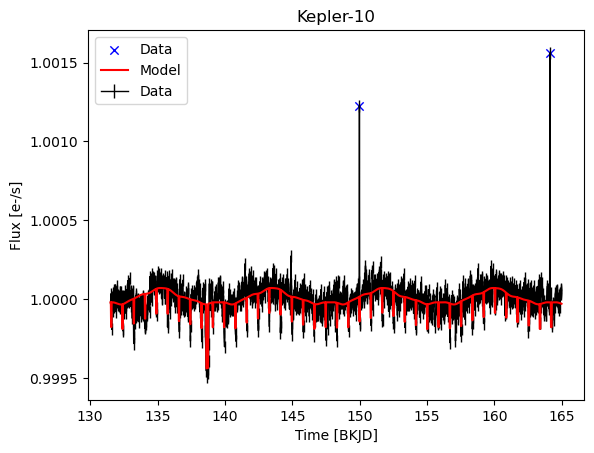

In [83]:
fig, ax = plt.subplots()
ax.errorbar(x, y, ye, color="k", lw=1, label="Data")
ax.scatter(x[outliers], y[outliers], color="b", lw=1, label="Data", marker='x')
ax.plot(x, A.dot(w), c="r", zorder=10, label="Model")
ax.set(xlabel="Time [BKJD]", ylabel="Flux [e-/s]", title="Kepler-10")

ax.legend()

In [49]:
w[-2:]

array([0.00025144, 0.03320677])

In [48]:
assert np.allclose(w[-2:], np.asarray([0.00015893, 0.00040655]), rtol=0.02)

AssertionError: 